<a href="https://colab.research.google.com/github/dkmachinelearning/dkmachinelearning/blob/main/dkml_BrisT1D_Blood_Glucose_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brist1d:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F82611%2F9553358%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T132518Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db150d6bbf531c8cd8b7c3140cbbb48e5bd9a356c39eee865558e0ed6f5fbe8bceef392e36a6ee6d076be3a2a4d49ef699d9e2e3c0e87c056107cac4a5ec7e795e9aa18af358905f85c7ffcaa0fbb7e3c814e6b47a6bec75cc3e43396994f9d3489481c52d4ec5af1f79c1578c85c10502bf69abeb141a137b79a0ef34283c37de4a3e5830d188e3fcdf36d821af23f406a805880ce1de2307f3940e40f891caba3ac3cb8be2d73246b1162fb2bd259ee585df028656a48508b699eb5c0e88c30d3a41f256511718b32cf959d7bb2863c00b00d139e42e45f99f1b48bf41b7ac7dc25d89b6e33a0adfcf69ae54ee728092827f01ba3f89c2b4afee7ffa1df8cdf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9652764 bytes downloaded
Downloaded and uncompressed: brist1d
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brist1d/activities.txt
/kaggle/input/brist1d/test.csv
/kaggle/input/brist1d/train.csv
/kaggle/input/brist1d/sample_submission.csv


In [7]:
#pip install missingno

In [3]:
train = pd.read_csv('/kaggle/input/brist1d/train.csv', low_memory=False)#
train = pd.DataFrame(train)
train.describe(include = 'all')

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
count,177024,177024,177024,149770.000000,158533.000000,163364.000000,149766.000000,158254.000000,163770.000000,149763.000000,...,2738,2748,2731,2733,2754,2731,2737,2753,2737,177024.000000
unique,177024,9,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21,21,21,21,22,22,22,22,22,NaN
top,p12_25259,p03,11:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Walk,Walk,Walk,Walk,Walk,Walk,Walk,Walk,Walk,NaN
freq,1,26028,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1980,1987,1977,1974,1992,1974,1975,1991,1973,NaN
mean,NaN,NaN,NaN,8.211018,8.230449,8.253291,8.210988,8.229649,8.254083,8.211049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.277045
std,NaN,NaN,NaN,2.852188,2.913438,2.945594,2.852090,2.911313,2.947651,2.852212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.996398
min,NaN,NaN,NaN,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.200000
25%,NaN,NaN,NaN,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.100000
50%,NaN,NaN,NaN,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.700000
75%,NaN,NaN,NaN,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.900000


In [4]:
#extraction columns with strictly numerich and other types of data
#numeric
numeric_cols = train.select_dtypes(exclude='object').columns
print(numeric_cols)

Index(['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30',
       'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10',
       ...
       'cals-0:40', 'cals-0:35', 'cals-0:30', 'cals-0:25', 'cals-0:20',
       'cals-0:15', 'cals-0:10', 'cals-0:05', 'cals-0:00', 'bg+1:00'],
      dtype='object', length=433)


In [5]:
#object - str od mixed type
object_cols = train.select_dtypes(include='object').columns
print(object_cols)

Index(['id', 'p_num', 'time', 'activity-5:55', 'activity-5:50',
       'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30',
       'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10',
       'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50',
       'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30',
       'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10',
       'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50',
       'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30',
       'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10',
       'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50',
       'activity-2:45', 'activity-2:40', 'activity-2:35', 'activity-2:30',
       'activity-2:25', 'activity-2:20', 'activity-2:15', 'activity-2:10',
       'activity-2:05', 'activity-2:00', 'activity-1:55', 'activity-1:50',
       'activity-1:45', 'activity-1:

In [8]:
#Handling missing values
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

In [9]:
print('Training data shape: ', train.shape)
#print('Testing data shape: ', test.shape)

Training data shape:  (177024, 508)


In [10]:
#pd.options.display.max_columns = 999
column = train['bg+1:00'].round(0)
pd.DataFrame(column.value_counts()).T

bg+1:00,6.0,7.0,8.0,5.0,9.0,10.0,11.0,12.0,4.0,13.0,...,20.0,22.0,21.0,2.0,23.0,28.0,24.0,25.0,27.0,26.0
count,31848,25657,25355,17282,16699,15805,10077,9027,7409,5088,...,312,150,122,83,14,9,8,7,5,3


In [ ]:
#sns.histplot(train['bg+1:00'])

In [ ]:
#sns.boxplot(train['bg+1:00'])

In [11]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction.
# One of the best notebooks on getting started with a ML problem.
#Function definition from Kaggle

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
train_missing= missing_values_table(train)
train_missing

Your selected dataframe has 508 columns.
There are 504 columns that have missing values.


,Missing Values,% of Total Values
carbs-4:30,174496,98.6
carbs-4:00,174492,98.6
carbs-4:45,174491,98.6
carbs-4:15,174490,98.6
carbs-5:30,174490,98.6
...,...,...
bg-1:00,5057,2.9
bg-0:45,4459,2.5
bg-0:30,3864,2.2
bg-0:15,3272,1.8


In [ ]:
#msno.bar(train)

<Axes: >

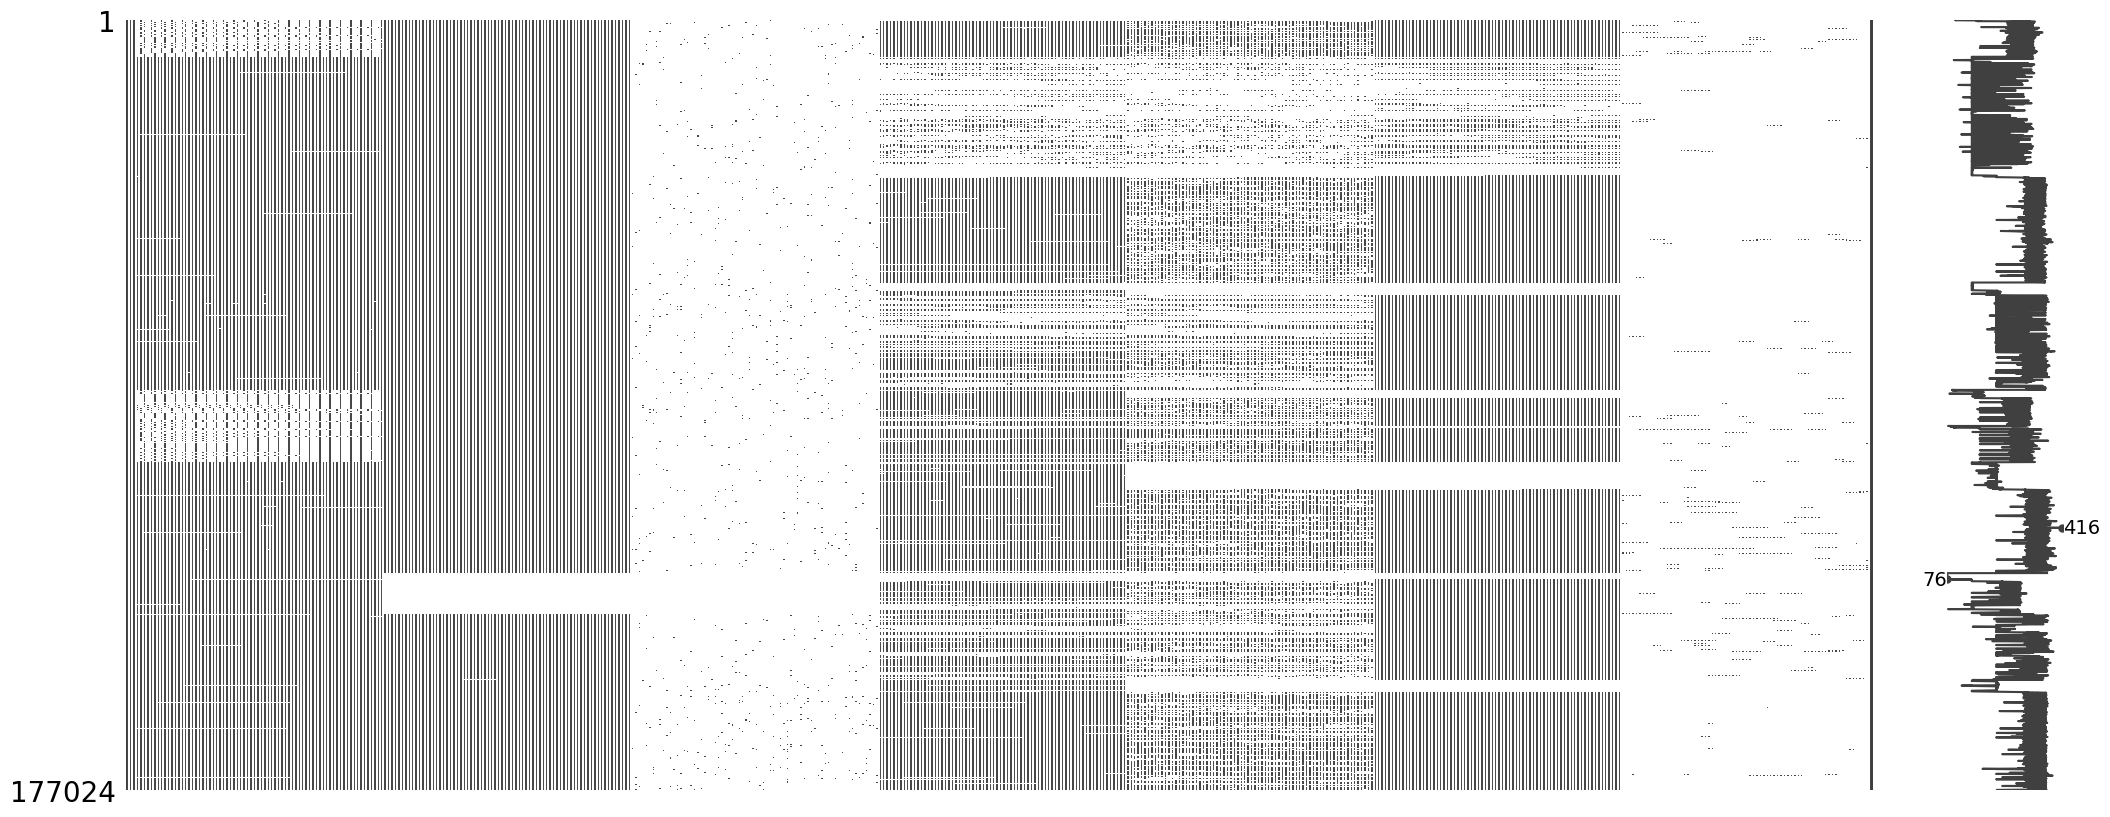

In [13]:
msno.matrix(train)
#msno.matrix(train.sample(100))

#too big for computing
#msno.heatmap(train)

#msno.dendrogram(train)

In [14]:
train[numeric_cols] = train[numeric_cols].fillna(0)
train[object_cols] = train[object_cols].fillna("0")

<Axes: >

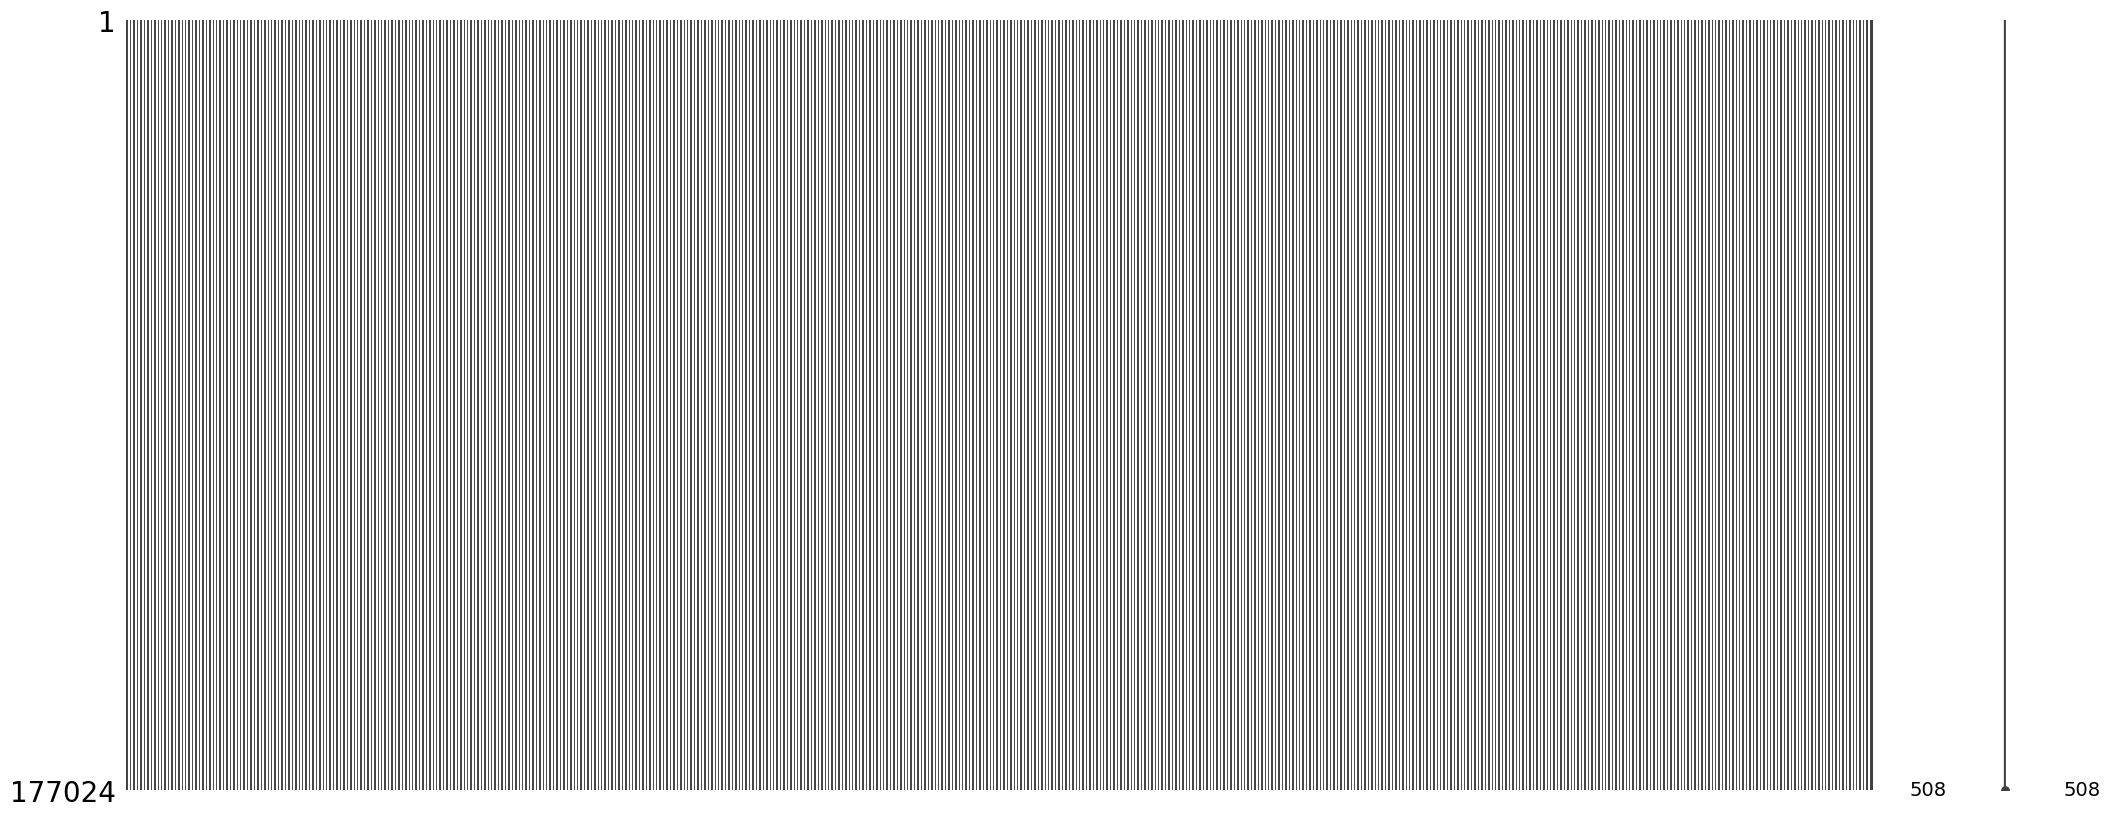

In [15]:
#Once again matrix for missings
msno.matrix(train)

In [16]:
train[object_cols].head(500)

,id,p_num,time,activity-5:55,activity-5:50,activity-5:45,activity-5:40,activity-5:35,activity-5:30,activity-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
0,p01_0,p01,06:10:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,p01_1,p01,06:25:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,p01_2,p01,06:40:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,p01_3,p01,06:55:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,p01_4,p01,07:10:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,p01_495,p01,16:20:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,p01_496,p01,16:35:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,p01_497,p01,16:50:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,p01_498,p01,17:05:00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform train object data
train[object_cols] = encoder.fit_transform(train[object_cols])
train[object_cols].describe()

,id,p_num,time,activity-5:55,activity-5:50,activity-5:45,activity-5:40,activity-5:35,activity-5:30,activity-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
count,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,...,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000
mean,88511.500000,4.259615,143.305823,0.239747,0.239318,0.237928,0.239369,0.238905,0.237521,0.238945,...,0.227020,0.227263,0.228088,0.226675,0.226766,0.241606,0.239442,0.239787,0.241425,0.239578
std,51102.571364,2.626331,82.713187,1.967618,1.965222,1.959796,1.966108,1.963315,1.957953,1.964440,...,1.859517,1.860400,1.863748,1.858080,1.858197,1.976358,1.967416,1.968260,1.975346,1.967090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44255.750000,2.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88511.500000,4.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,132767.250000,7.000000,214.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,177023.000000,8.000000,287.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,22.000000,22.000000,22.000000,22.000000,22.000000


In [ ]:
#scaling to 0-1
## this will be later on

In [18]:
#the same for test data
val = pd.read_csv('/kaggle/input/brist1d/test.csv', low_memory=False)#
val = pd.DataFrame(val)
val.describe(include = 'all')

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
count,3644,3644,3644,2660.000000,3061.000000,3158.000000,2658.000000,3045.000000,3169.000000,2655.000000,...,66,62,65,66,61,64,57,58,63,61
unique,3644,15,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,11,11,11,11,12,12,11,12,10
top,p24_260,p15,12:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Walk,Walk,Walk,Walk,Walk,Walk,Walk,Walk,Walk,Walk
freq,1,294,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38,36,39,44,39,39,33,35,41,41
mean,NaN,NaN,NaN,8.566654,8.688860,8.715389,8.563845,8.666798,8.692143,8.546102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.984747,3.111116,3.214752,2.956948,3.084045,3.172040,2.903702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2.800000,2.200000,2.600000,2.200000,2.400000,2.500000,2.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,6.400000,6.400000,6.500000,6.500000,6.400000,6.500000,6.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,7.900000,8.000000,8.000000,7.900000,8.000000,7.900000,7.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,10.200000,10.400000,10.400000,10.200000,10.300000,10.300000,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#extraction columns with strictly numerich and other types of data
#numeric
numeric_cols = val.select_dtypes(exclude='object').columns
print(numeric_cols)


Index(['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30',
       'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10',
       ...
       'cals-0:45', 'cals-0:40', 'cals-0:35', 'cals-0:30', 'cals-0:25',
       'cals-0:20', 'cals-0:15', 'cals-0:10', 'cals-0:05', 'cals-0:00'],
      dtype='object', length=432)


In [20]:
#object - str od mixed type
object_cols = val.select_dtypes(include='object').columns
print(object_cols)


Index(['id', 'p_num', 'time', 'activity-5:55', 'activity-5:50',
       'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30',
       'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10',
       'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50',
       'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30',
       'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10',
       'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50',
       'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30',
       'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10',
       'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50',
       'activity-2:45', 'activity-2:40', 'activity-2:35', 'activity-2:30',
       'activity-2:25', 'activity-2:20', 'activity-2:15', 'activity-2:10',
       'activity-2:05', 'activity-2:00', 'activity-1:55', 'activity-1:50',
       'activity-1:45', 'activity-1:

In [21]:
val_missing= missing_values_table(val)
val_missing


Your selected dataframe has 507 columns.
There are 504 columns that have missing values.


,Missing Values,% of Total Values
activity-5:05,3614,99.2
activity-5:10,3614,99.2
activity-5:20,3612,99.1
activity-5:15,3611,99.1
activity-5:00,3611,99.1
...,...,...
insulin-5:45,157,4.3
insulin-5:40,157,4.3
insulin-5:30,157,4.3
insulin-5:35,157,4.3


<Axes: >

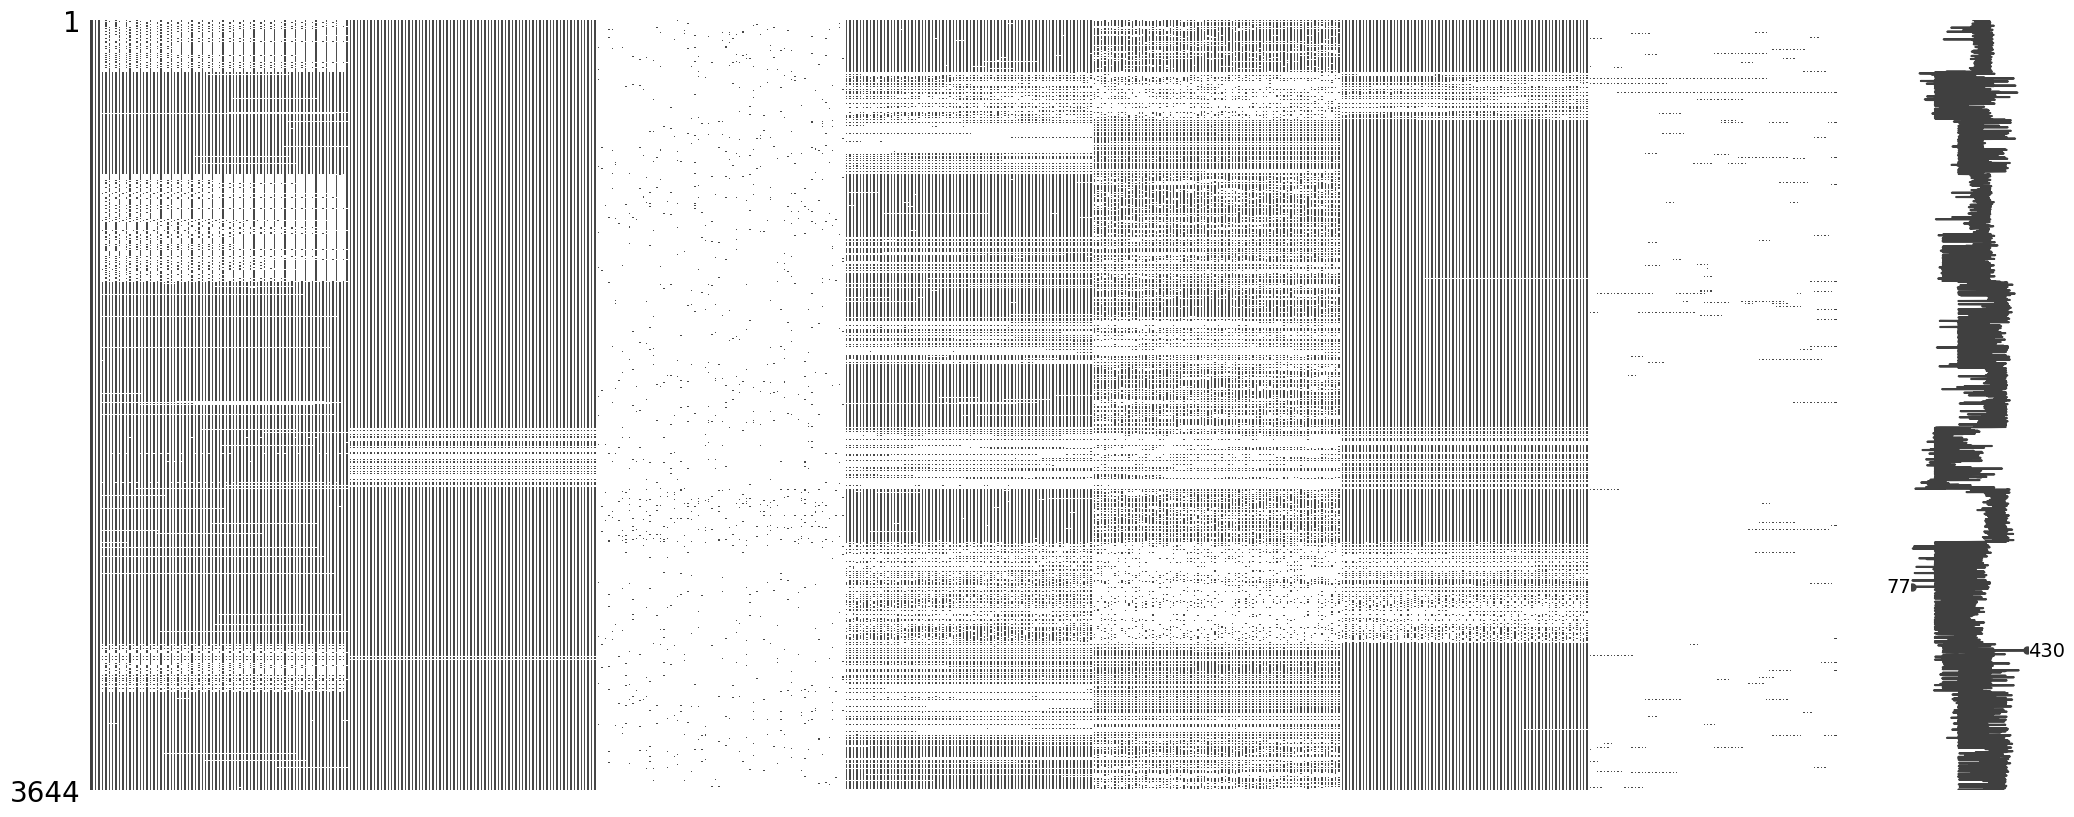

In [22]:
msno.matrix(val)

In [23]:
val[numeric_cols] = val[numeric_cols].fillna(0)
val[object_cols] = val[object_cols].fillna("0")


<Axes: >

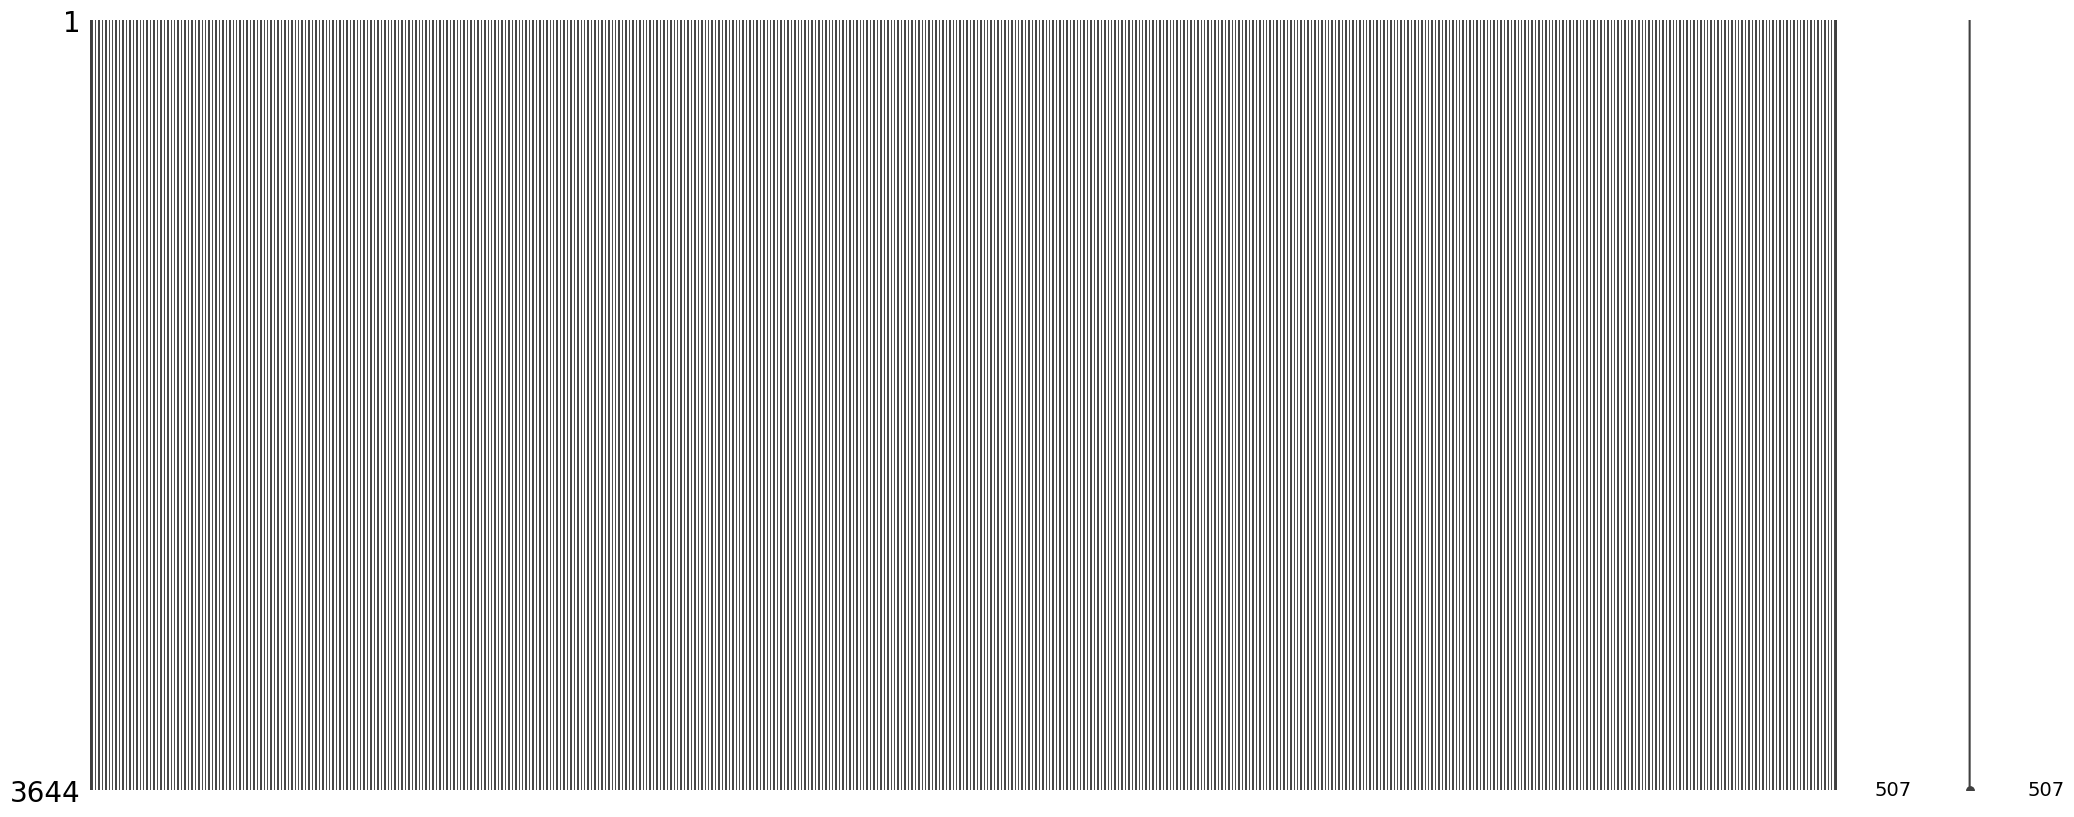

In [24]:
msno.matrix(val)

In [25]:
#from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform test object data
val[object_cols] = encoder.fit_transform(val[object_cols])
val[object_cols].describe()


,id,p_num,time,activity-5:55,activity-5:50,activity-5:45,activity-5:40,activity-5:35,activity-5:30,activity-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,...,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,1821.500000,6.982162,142.887212,0.063392,0.048847,0.034577,0.033754,0.030461,0.021679,0.021679,...,0.131723,0.126784,0.146268,0.154226,0.141877,0.162184,0.144621,0.133919,0.162184,0.128705
std,1052.076518,4.296895,83.078667,0.573061,0.457141,0.336148,0.332538,0.317665,0.227946,0.227946,...,1.021962,1.004987,1.134762,1.167936,1.120964,1.253614,1.186527,1.087024,1.257767,1.009512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,910.750000,3.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1821.500000,7.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2732.250000,11.000000,216.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3643.000000,14.000000,287.000000,7.000000,6.000000,5.000000,5.000000,5.000000,4.000000,4.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,12.000000,12.000000,11.000000,12.000000,10.000000


In [ ]:
#from sklearn.preprocessing import StandardScaler
## define data
#data = asarray([[100, 0.001],
 #[8, 0.05],
 #[50, 0.005],
 #[88, 0.07],
 #[4, 0.1]])
#print(data)
## define standard scaler
#scaler = StandardScaler()
## transform data
#scaled = scaler.fit_transform(data)
#print(scaled)


In [26]:
train.columns

Index(['id', 'p_num', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40',
       'bg-5:35', 'bg-5:30', 'bg-5:25',
       ...
       'activity-0:40', 'activity-0:35', 'activity-0:30', 'activity-0:25',
       'activity-0:20', 'activity-0:15', 'activity-0:10', 'activity-0:05',
       'activity-0:00', 'bg+1:00'],
      dtype='object', length=508)

In [27]:
X = train.drop(['id', 'p_num', 'time', 'bg+1:00'], axis = 1)
y = train['bg+1:00']
#X_val = test.drop(['id', 'p_num', 'time'], axis = 1)

In [28]:
#Simple regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# Create model
model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# The mean squared error
print(f"RMSE: {round(mean_squared_error(y_test, y_pred, squared = False),2)}\t\t R2 score: {round(r2_score(y_test, y_pred),2)}%")

RMSE: 2.17		 R2 score: 0.48%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

start_time = time.time()

#Serching for a few models
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, Perceptron, PassiveAggressiveRegressor, RANSACRegressor
regressors = {
"LinearRegression"                 : LinearRegression()
,"ElasticNet"                      : ElasticNet(random_state = 123)
,"HistGradientBoostingRegressor"         : HistGradientBoostingRegressor()
, "RandomForestRegressor": RandomForestRegressor()
, "Perceptron"                     : Perceptron()
    , "PassiveAggressiveRegressor": PassiveAggressiveRegressor()
 , "RANSACRegressor": RANSACRegressor()
    , "KernelRidge": KernelRidge()
    , "SVR": SVR()
    , "KNeighborsRegressor": KNeighborsRegressor()
    , "GaussianProcessRegressor": GaussianProcessRegressor()
    , "DecisionTreeRegressor": DecisionTreeRegressor()
    , "GaussianNB": GaussianNB()
    , "MultinomialNB": MultinomialNB()
    , "ComplementNB": ComplementNB()
    , "BernoulliNB": BernoulliNB()
    , "CategoricalNB": CategoricalNB()
    ,"SGDRegressor"                    : SGDRegressor()
}

best_model = (None, 0.0)
for name, model in regressors.items():
    #print(name)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        RMSE = round(mean_squared_error(y_test, y_pred, squared=True),2)

        if RMSE < best_model[1]:
            best_model = (name, RMSE)

        print(f"RMSE: {RMSE}\t\t R2 score: {round(r2_score(y_test, y_pred),2)}%\t\t{name}")

print("\nBest regressor is ",best_model[0])

# now I peek the best and train it with all the data availble
#model.fit(X,y)
end_time = time.time()
print(f"Execution time: {(end_time - start_time)/60:.2f} minutes")

RMSE: 4.7		 R2 score: 0.48%		LinearRegression
RMSE: 5.19		 R2 score: 0.42%		ElasticNet
RMSE: 3.6		 R2 score: 0.6%		HistGradientBoostingRegressor
